# PSO optimizer for CNN
---

- Look at this dataset here: https://www.kaggle.com/mlg-ulb/creditcardfraud
- Can you please create a CNN for this dataset and optimise its hyperparametrs using PSO.
- Check this out: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Classification.ipynb

- Basically just wanted to use PSO as optimizer for cnn..


# README.md
---
## Data and task 
- The csv file contains 31 columns including the class column which tells us if this perticular column is fraud or not 
- This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions
- Because we have such an imballanced distrubtion of classes we can not directly train our classifier otherwise it will quickly learn to predict everything as not fraud and will have very good acuracy
- So to deal with this skwed dataset we use only the 492 non fraud rows data along with 492 fraud data to make our classifer learn from features
- The non-fraud 492 rows of data are choosen randomly and total we get 492+492 = 984 rows of data to train our model.
- **More advance model will take the random non-fraud rows randomly from all data in every epoch**
- Then we split these 984 rows into train and testing data, taking 75% in training and 25% in testing. And they are choosen randomly from these 984 rows.
- Then we use standard scalling to scale down our data for better gradient descent optimization.
&nbsp;

- ![image.png](https://i.stack.imgur.com/obywE.png)
&nbsp;

- Then we reshape our data as 3d Data to make it process in convolutional neural network

&nbsp;
## The Model
---
- ![image.png](https://d2l.ai/_images/conv1d-channel.svg)
&nbsp;
- In model we first have 32 conv layers followed by 64 layers in second layer then we flatten the data to send it inside the NN
- the NN have 2 layers and a final softmax layer with 2 nurons to predict our classes (fraud or not)
- Inside the NN the no of Nuron for each layer is decided via the optimizer
- **In advance model we can also try changing the CNN kernal size and layers based on optimizer only**

- With in the search dict we give the our optimizer a range of values to try upon to get to global minima of opotimization

## particle swarm optimization
---
- we define a searh dict along with all the ranges optimizer can try upon
- then we define `performance` which takes `@optunity` as decorator and with in this we call our model and return the score(eg: accuracy) for the model 
- then we use `optunity.maximize` function and give it the `performance` function to give us the configuration to acchive the best hyper parameters.
- finally we train our new model on given hyper parameters and plot the confusion matrix 
&nbsp;
- ![image.png](https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png)
&nbsp;
- Then we can get these values from confussion matrix.
![image.png](https://i.stack.imgur.com/U0hjG.png)

In [1]:
# Tensforflow libraries
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPool1D

# Data processing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

print(tf.__version__)

2.4.0


In [2]:
plt.style.use('ggplot')

## Importing Data from CSV

In [3]:
data = pd.read_csv("./creditcard.csv")

## Exploring the Dataset
* This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions
* features V1 - V28 are a result of the PCA transformation and are simply numerical representations.
* Amount is the value in dollars of the transaction
* Time variable is the amount of time that passed from the time when the first transaction took place.
* Fraud = 1 , Not Fraud = 0

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# checking for any null value
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
# splitting fraud and non-fraud rows
non_fraud_data = data[data['Class']==0]
fraud_data = data[data['Class']==1]

In [9]:
non_fraud_data.shape, fraud_data.shape

((284315, 31), (492, 31))

In [10]:
non_fraud_data_sample = non_fraud_data.sample(fraud_data.shape[0])

non_fraud_data_sample.shape

(492, 31)

In [11]:
# balance dataset: rows 492(fraud) + 492 (non-fraud)
bal_data = fraud_data.append(non_fraud_data_sample,ignore_index = True) 
bal_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,36998.0,1.230693,-0.365261,0.742048,0.487720,-0.632840,0.641506,-0.893742,0.408261,1.049004,...,-0.142992,-0.330543,-0.096466,-0.843308,0.315986,0.378565,-0.000189,0.000078,3.07,0
980,160299.0,2.038722,-0.179165,-1.102199,0.427829,-0.239450,-1.158529,0.088295,-0.234594,0.742806,...,-0.294543,-0.789361,0.356820,-0.049679,-0.361563,0.204811,-0.077694,-0.062148,8.90,0
981,48321.0,1.123743,0.085947,-0.051770,1.193853,0.392704,0.438560,0.210142,-0.038833,0.163345,...,-0.118104,-0.168624,-0.253358,-0.888888,0.818116,-0.260225,0.035837,0.018551,66.67,0
982,153058.0,-0.201676,0.637988,-1.912946,-0.984388,1.815605,-1.509623,1.753633,-0.688360,-0.477702,...,0.538124,1.952468,0.149749,-0.272536,-1.059626,0.079458,-0.007980,0.254160,6.13,0


In [12]:
bal_data['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

## Splitting Features and labels
* Features = Time, v1, v2 ....
* Label/Target = Class

In [13]:
features = bal_data.drop('Class',axis=1)
labels = bal_data['Class']

In [14]:
features_train,features_test,labels_train,labels_test = train_test_split(features,labels,test_size=.25,random_state=41,stratify = labels)

In [15]:
features_train.shape, features_test.shape

((738, 30), (246, 30))

In [16]:
labels_test.value_counts()
features_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
234,70229.0,0.315642,1.636778,-1.519650,4.028571,-1.186794,-0.789813,-2.279807,0.472988,-1.657635,...,0.388885,0.345921,-0.108002,-0.165442,0.279895,0.808783,0.117363,0.589595,0.309064,3.79
141,42247.0,-2.524012,2.098152,-4.946075,6.456588,3.173921,-3.058806,-0.184710,-0.390420,-3.649812,...,-0.162797,0.027935,0.220366,0.976348,-0.290539,1.161002,0.663954,0.456023,-0.405682,1.00
871,120944.0,-1.334501,0.812430,1.895905,-0.472414,0.607191,0.321986,0.847528,0.199140,0.119934,...,-0.403466,-0.490213,-1.379013,-0.316627,-0.490907,0.591407,-1.179351,-0.180483,0.027394,34.97
143,42985.0,-4.075975,0.963031,-5.076070,4.955963,-0.161437,-2.832663,-7.619765,1.618895,-2.992092,...,0.058861,1.030738,0.165328,-1.017502,-0.477983,-0.304987,-0.106089,1.899714,0.511462,1.00
65,26863.0,-21.209120,12.652197,-23.553933,6.174078,-16.026658,-4.422195,-16.229444,14.116002,-3.922741,...,1.602439,1.758440,-1.522588,-0.903860,0.130166,1.454857,-0.223214,1.550928,0.461460,99.99


## Scaling the Database

In [17]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.fit_transform(features_test)

# converting features into dataframe
features_train = pd.DataFrame(features_train)
features_test = pd.DataFrame(features_test)

## Reshaping the database into 3D
* We are using CNN for prediction so converting 2D dataset into 3D

In [18]:
features_train = features_train.to_numpy()
features_test = features_test.to_numpy()

In [19]:
features_train = features_train.reshape(features_train.shape[0],features_train.shape[1],1)
features_test = features_test.reshape(features_test.shape[0],features_test.shape[1],1)

features_train.shape, features_test.shape

((738, 30, 1), (246, 30, 1))

In [20]:
labels_train.shape

(738,)

## Build CNN (Convolutional Neural Network)

In [52]:
# defining the hyperparameter
epochs = 45
model = Sequential()

# FIRST LAYER
model.add(Conv1D(32,2,activation = 'relu',input_shape = features_train[0].shape))
model.add(BatchNormalization())
'''Batch normalization is a technique for training very deep neural networks 
   that standardizes the inputs to a layer for each mini-batch. This 
   has the effect of stabilizing the learning process and dramatically
   reducing the number of training epochs required to train deep networks'''
model.add(Dropout(0.2)) # prevents over-fitting (randomly remove some neurons)

# SECOND LAYER
model.add(Conv1D(64,2,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Flattening the layer ( multidimentional data into vector)
model.add(Flatten())
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.5))

# FINAL LAYER
model.add(Dense(2,activation='sigmoid')) # binary classification 


In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_4 (Batch (None, 29, 32)            128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 29, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 64)            256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1792)             

In [54]:
# optimizing the model 
model.compile(optimizer = Adam(lr=0.0001),loss = 'binary_crossentropy',metrics=['accuracy'])

In [113]:
# Training the model, Calculating the accuracy 
history = model.fit(features_train, pd.get_dummies(labels_train).values, epochs = epochs,
                    validation_data = (features_test,pd.get_dummies(labels_test).values),verbose = 1)

# pd.get_dummies(labels_test).values   is to make 0-1 float data into one-hot encoding 

Epoch 1/45
24/24 [==============================] - 0s 17ms/step - loss: 0.1207 - accuracy: 0.9607 - val_loss: 0.1624 - val_accuracy: 0.9472
Epoch 2/45
24/24 [==============================] - 0s 14ms/step - loss: 0.1282 - accuracy: 0.9553 - val_loss: 0.1413 - val_accuracy: 0.9512
Epoch 3/45
24/24 [==============================] - 0s 15ms/step - loss: 0.1186 - accuracy: 0.9539 - val_loss: 0.1358 - val_accuracy: 0.9512
Epoch 4/45
24/24 [==============================] - 0s 14ms/step - loss: 0.1164 - accuracy: 0.9526 - val_loss: 0.1483 - val_accuracy: 0.9553
Epoch 5/45
24/24 [==============================] - 0s 18ms/step - loss: 0.1291 - accuracy: 0.9539 - val_loss: 0.1371 - val_accuracy: 0.9390
Epoch 6/45
24/24 [==============================] - 0s 19ms/step - loss: 0.1096 - accuracy: 0.9688 - val_loss: 0.1506 - val_accuracy: 0.9472
Epoch 7/45
24/24 [==============================] - 0s 17ms/step - loss: 0.1136 - accuracy: 0.9593 - val_loss: 0.1422 - val_accuracy: 0.9472
Epoch 8/45
24

### Prediction on Train+Test set

In [114]:
features_all = np.append(features_train,features_test, axis=0)
labels_all = np.append(labels_train,labels_test, axis=0)
features_all.shape, labels_all.shape

((984, 30, 1), (984,))

In [115]:
predicted_labels_all = model.predict(features_all,verbose=1)

31/31 [==============================] - 0s 3ms/step


In [116]:
cm = confusion_matrix(labels_all,predicted_labels_all.argmax(axis=1))
cm

array([[490,   2],
       [ 26, 466]])

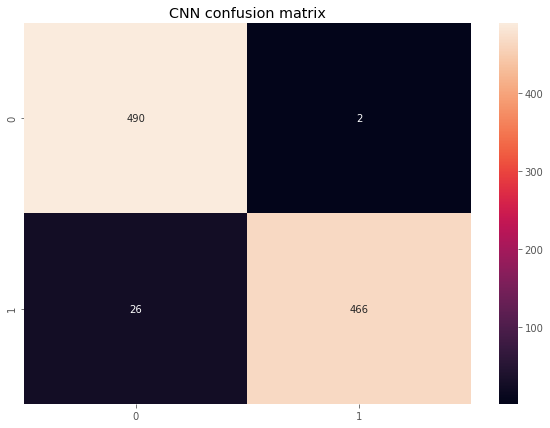

In [121]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cm

df_cm = pd.DataFrame(array)
plt.figure(figsize = (10,7))
plt.title("CNN confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')


In [145]:
def plot_classification_report(report):
    '''
    This will plot graph of classification_reports
    '''
    plt.figure(figsize = (10,8))
    g=sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True , fmt=".4%")
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    
    
def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_________________")
        print(f"Classification Report:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {cm}\n")
        print("\n")
        plot_classification_report(clf_report)
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_________________")
        print(f"Classification Report:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {cm}\n")
        print("\n")
        plot_classification_report(clf_report)

Train Result:
Accuracy Score: 95.43%
_________________
Classification Report:
                    0           1  accuracy   macro avg  weighted avg
precision    0.919325    0.995565  0.954268    0.957445      0.957445
recall       0.995935    0.912602  0.954268    0.954268      0.954268
f1-score     0.956098    0.952280  0.954268    0.954189      0.954189
support    492.000000  492.000000  0.954268  984.000000    984.000000
_________________
Confusion Matrix: 
 [[490   2]
 [ 43 449]]





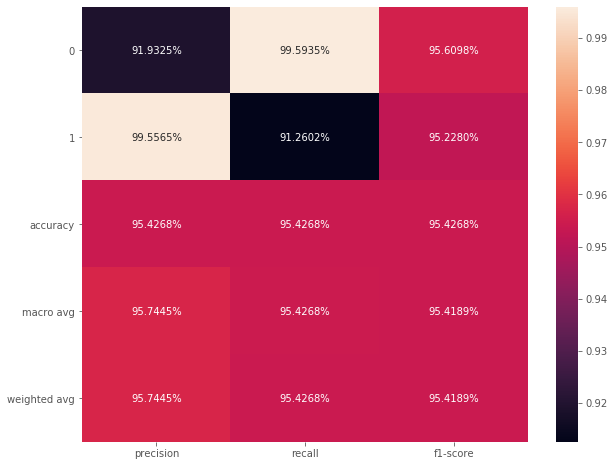

In [146]:
print_score(labels_all, predicted_labels_all.argmax(axis=1))

## Plotting a Learning Curve

In [61]:
def plot_learning_curve(history,epochs):
    
    # plot training and validation accuracy 
    plt.figure(figsize=(20,8))
    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()
    plt.figure(figsize=(20,8))
    # plot training and validation loss
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()

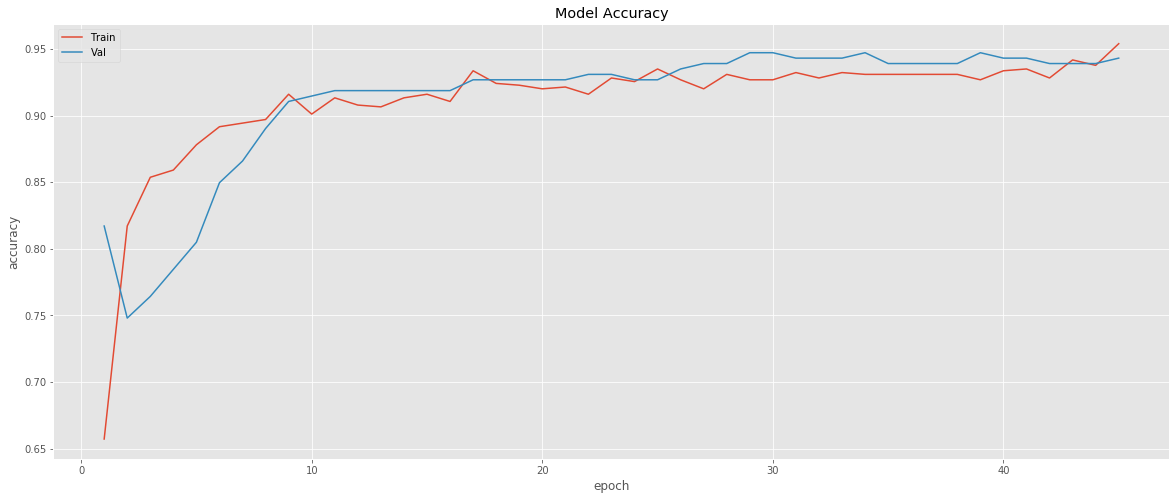

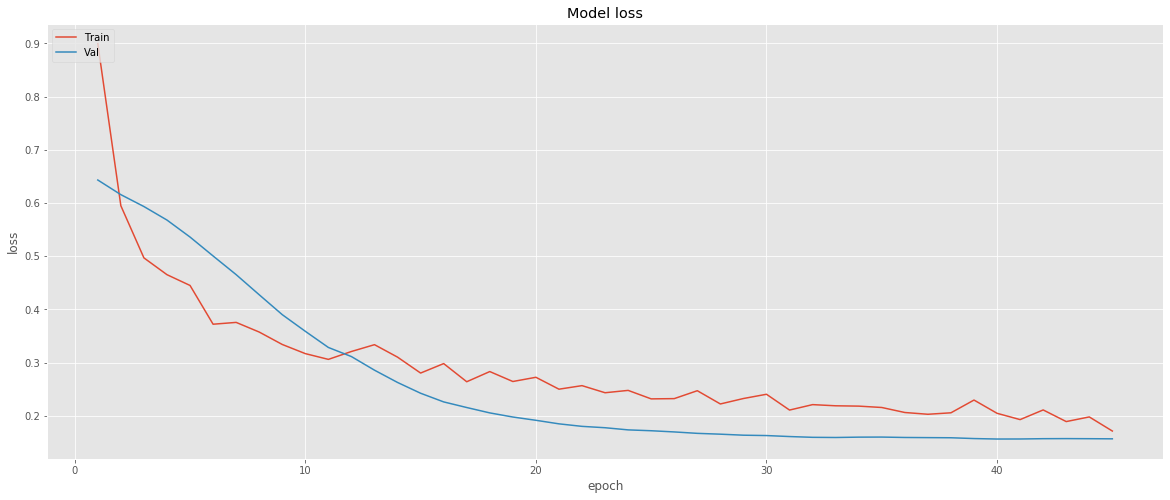

In [62]:
plot_learning_curve(history,epochs)

## Using particle swarm optimization 

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats

In [36]:
import optunity
import optunity.metrics

In [70]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

def CNN(optimizer = 'sgd',neurons=32,batch_size=32,epochs=20,activation='relu',patience=3,loss='categorical_crossentropy'):
    model = Sequential()
    model.add(Conv1D(neurons,2,activation = activation,input_shape=X[0].shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # SECOND LAYER
    model.add(Conv1D(2*neurons,2,activation = activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Flatten())
    
    model.add(Dense(2*neurons, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))  
    
    model.compile(optimizer = optimizer, loss=loss, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor="loss", patience = patience)# early stop patience
    history = model.fit(X, pd.get_dummies(y).values,
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping],
              verbose=1) #verbose set to 1 will show the training process
    return model

In [67]:
#ANN
import optunity
import optunity.metrics
from tqdm import tqdm

X = features_train
y = labels_train

data=X
labels=y.tolist()

MODEL = False

search = {
    'optimizer':[0,3],
    'activation':[0,2],
    'batch_size': [0, 2],
    'neurons': [32, 64],
    'epochs': [20, 50],
    'patience': [3, 20],
         }
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test,optimizer=None,activation=None,batch_size=None,neurons=None,epochs=None,patience=None):
    # fit the model
    
    if optimizer<1:
        op='adam'
    elif optimizer<2:
        op='sgd'
    else:
        op='rmsprop'
    if activation<1:
        ac='relu'
    else:
        ac='tanh'
    if batch_size<1:
        ba=16
    else:
        ba=32
    model = CNN(optimizer=op,
                activation=ac,
                batch_size=ba,
                neurons=int(neurons),
                epochs=int(epochs),
                patience=int(patience)
                )
    
    clf = KerasClassifier(build_fn=CNN, verbose=0)
    scores=np.mean(cross_val_score(clf, X, y, cv=3, 
                                    scoring="accuracy"))

    return scores

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("MSE:"+ str(info.optimum))

Epoch 1/31
24/24 [==============================] - 1s 6ms/step - loss: 1.0326
Epoch 2/31
24/24 [==============================] - 0s 8ms/step - loss: 0.3459
Epoch 3/31
24/24 [==============================] - 0s 7ms/step - loss: 0.3047
Epoch 4/31
24/24 [==============================] - 0s 7ms/step - loss: 0.3054
Epoch 5/31
24/24 [==============================] - 0s 6ms/step - loss: 0.3033
Epoch 6/31
24/24 [==============================] - 0s 6ms/step - loss: 0.2551
Epoch 7/31
24/24 [==============================] - 0s 8ms/step - loss: 0.2168
Epoch 8/31
24/24 [==============================] - 0s 11ms/step - loss: 0.2357
Epoch 9/31
24/24 [==============================] - 0s 6ms/step - loss: 0.2409
Epoch 10/31
24/24 [==============================] - 0s 7ms/step - loss: 0.2253
Epoch 11/31
24/24 [==============================] - 0s 7ms/step - loss: 0.2407
Epoch 12/31
24/24 [==============================] - 0s 8ms/step - loss: 0.1922
Epoch 13/31
24/24 [=============================

/home/vaibhav/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/20
24/24 [==============================] - 1s 5ms/step - loss: 0.8955
Epoch 2/20
24/24 [==============================] - 0s 7ms/step - loss: 0.4245
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3614
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3000
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3005
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2470
Epoch 7/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2698
Epoch 8/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2501
Epoch 9/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2641
Epoch 10/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2339
Epoch 1/20
24/24 [==============================] - 1s 6ms/step - loss: 0.9026
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 0.4498
Epoch 3/20
24/24 [==============================] -

24/24 [==============================] - 0s 7ms/step - loss: 0.1994
Epoch 17/31
24/24 [==============================] - 0s 6ms/step - loss: 0.2018
Epoch 18/31
24/24 [==============================] - 0s 7ms/step - loss: 0.2133
Epoch 19/31
24/24 [==============================] - 0s 7ms/step - loss: 0.1925
Epoch 20/31
24/24 [==============================] - 0s 6ms/step - loss: 0.1534
Epoch 21/31
24/24 [==============================] - 0s 6ms/step - loss: 0.1973
Epoch 22/31
24/24 [==============================] - 0s 6ms/step - loss: 0.1564
Epoch 23/31
24/24 [==============================] - 0s 7ms/step - loss: 0.1620
Epoch 24/31
24/24 [==============================] - 0s 6ms/step - loss: 0.1490
Epoch 25/31
24/24 [==============================] - 0s 6ms/step - loss: 0.1651
Epoch 26/31
24/24 [==============================] - 0s 6ms/step - loss: 0.1829
Epoch 27/31
24/24 [==============================] - 0s 6ms/step - loss: 0.2089
Epoch 28/31
24/24 [==============================] -

Epoch 9/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2143
Epoch 10/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2536
Epoch 11/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2288
Epoch 12/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2590
Epoch 13/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2008
Epoch 14/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2027
Epoch 15/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2261
Epoch 16/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2246
Epoch 17/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1593
Epoch 18/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1581
Epoch 19/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2317
Epoch 20/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1953
Epoch 1/20
24/24 [=======================

24/24 [==============================] - 0s 6ms/step - loss: 0.3841
Epoch 3/20
24/24 [==============================] - 0s 5ms/step - loss: 0.4149
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3471
Epoch 5/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3322
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2390
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2478
Epoch 8/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2303
Epoch 9/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2296
Epoch 10/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2426
Epoch 11/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2207
Epoch 12/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2101
Epoch 13/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2013
Epoch 14/20
24/24 [==============================] - 0s 6ms

47/47 [==============================] - 0s 5ms/step - loss: 0.2584
Epoch 4/38
47/47 [==============================] - 0s 5ms/step - loss: 0.2573
Epoch 5/38
47/47 [==============================] - 0s 5ms/step - loss: 0.2397
Epoch 6/38
47/47 [==============================] - 0s 5ms/step - loss: 0.3177
Epoch 7/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1358
Epoch 8/38
47/47 [==============================] - 0s 5ms/step - loss: 0.2015
Epoch 9/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1872
Epoch 10/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1765
Epoch 11/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1761
Epoch 12/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1278
Epoch 13/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1767
Epoch 14/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1485
Epoch 15/38
47/47 [==============================] - 0s 5m

47/47 [==============================] - 0s 5ms/step - loss: 0.1372
Epoch 26/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1333
Epoch 27/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1558
Epoch 28/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1501
Epoch 29/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1607
Epoch 30/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1285
Epoch 31/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1294
Epoch 32/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1064
Epoch 33/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1334
Epoch 34/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1606
Epoch 35/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1286
Epoch 36/38
47/47 [==============================] - 0s 5ms/step - loss: 0.1248
Epoch 37/38
47/47 [==============================] -

24/24 [==============================] - 0s 5ms/step - loss: 0.2311
Epoch 9/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2312
Epoch 10/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2259
Epoch 11/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2403
Epoch 12/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2061
Epoch 13/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2251
Epoch 14/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2076
Epoch 15/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1987
Epoch 1/20
24/24 [==============================] - 1s 5ms/step - loss: 0.7877
Epoch 2/20
24/24 [==============================] - 0s 5ms/step - loss: 0.4210
Epoch 3/20
24/24 [==============================] - 0s 7ms/step - loss: 0.2817
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2858
Epoch 5/20
24/24 [==============================] - 0s 6m

Epoch 14/20
24/24 [==============================] - 0s 7ms/step - loss: 0.2028
Epoch 15/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2477
Epoch 16/20
24/24 [==============================] - 0s 4ms/step - loss: 0.1787
Epoch 17/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2051
Epoch 18/20
24/24 [==============================] - 0s 4ms/step - loss: 0.1861
Epoch 19/20
24/24 [==============================] - 0s 4ms/step - loss: 0.1823
Epoch 20/20
24/24 [==============================] - 0s 4ms/step - loss: 0.1932
Epoch 1/23
24/24 [==============================] - 1s 8ms/step - loss: 0.7736
Epoch 2/23
24/24 [==============================] - 0s 8ms/step - loss: 0.2760
Epoch 3/23
24/24 [==============================] - 0s 8ms/step - loss: 0.2459
Epoch 4/23
24/24 [==============================] - 0s 8ms/step - loss: 0.2350
Epoch 5/23
24/24 [==============================] - 0s 9ms/step - loss: 0.2075
Epoch 6/23
24/24 [===========================

24/24 [==============================] - 1s 4ms/step - loss: 0.8978
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3736
Epoch 3/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3231
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2902
Epoch 5/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3158
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2371
Epoch 7/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2563
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2109
Epoch 9/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2058
Epoch 10/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2450
Epoch 11/20
24/24 [==============================] - 0s 4ms/step - loss: 0.1971
Epoch 12/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2178
Epoch 13/20
24/24 [==============================] - 0s 6ms/

24/24 [==============================] - 0s 4ms/step - loss: 0.2761
Epoch 6/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2260
Epoch 7/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2403
Epoch 8/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2169
Epoch 9/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2297
Epoch 1/20
24/24 [==============================] - 1s 4ms/step - loss: 0.9344
Epoch 2/20
24/24 [==============================] - 0s 4ms/step - loss: 0.4708
Epoch 3/20
24/24 [==============================] - 0s 4ms/step - loss: 0.3233
Epoch 4/20
24/24 [==============================] - 0s 4ms/step - loss: 0.3095
Epoch 5/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2595
Epoch 6/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2141
Epoch 7/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2406
Epoch 8/20
24/24 [==============================] - 0s 4ms/step

24/24 [==============================] - 0s 8ms/step - loss: 0.2954
Epoch 5/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3189
Epoch 6/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2768
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.2294
Epoch 8/20
24/24 [==============================] - 0s 10ms/step - loss: 0.2183
Epoch 9/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2509
Epoch 10/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2440
Epoch 11/20
24/24 [==============================] - 0s 10ms/step - loss: 0.2668
Epoch 1/20
24/24 [==============================] - 1s 10ms/step - loss: 0.8842
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3485
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.3152
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2825
Epoch 5/20
24/24 [==============================] - 0s 8m

24/24 [==============================] - 0s 6ms/step - loss: 0.1857
Epoch 18/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1677
Epoch 1/20
24/24 [==============================] - 1s 5ms/step - loss: 0.8317
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3976
Epoch 3/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3764
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3240
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3100
Epoch 6/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2848
Epoch 7/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2210
Epoch 8/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1929
Epoch 9/20
24/24 [==============================] - 0s 6ms/step - loss: 0.1754
Epoch 10/20
24/24 [==============================] - 0s 6ms/step - loss: 0.1905
Epoch 11/20
24/24 [==============================] - 0s 6ms/s

24/24 [==============================] - 0s 10ms/step - loss: 0.2033
Epoch 13/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2006
Epoch 14/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1738
Epoch 15/20
24/24 [==============================] - 0s 6ms/step - loss: 0.1984
Epoch 16/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1821
Epoch 17/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1621
Epoch 18/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2303
Epoch 19/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1861
Epoch 20/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1660
Epoch 1/20
24/24 [==============================] - 1s 6ms/step - loss: 0.8195
Epoch 2/20
24/24 [==============================] - 0s 7ms/step - loss: 0.4935
Epoch 3/20
24/24 [==============================] - 0s 7ms/step - loss: 0.4363
Epoch 4/20
24/24 [==============================] - 0s

24/24 [==============================] - 0s 6ms/step - loss: 0.3120
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2951
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3147
Epoch 6/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2338
Epoch 7/20
24/24 [==============================] - 0s 7ms/step - loss: 0.2177
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2146
Epoch 9/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2248
Epoch 10/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2300
Epoch 11/20
24/24 [==============================] - 0s 6ms/step - loss: 0.1874
Epoch 12/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2265
Epoch 13/20
24/24 [==============================] - 0s 6ms/step - loss: 0.1653
Epoch 14/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2167
Epoch 15/20
24/24 [==============================] - 0s 5m

47/47 [==============================] - 0s 11ms/step - loss: 0.1295
Epoch 13/37
47/47 [==============================] - 0s 9ms/step - loss: 0.1143
Epoch 14/37
47/47 [==============================] - 0s 9ms/step - loss: 0.1661
Epoch 15/37
47/47 [==============================] - 0s 10ms/step - loss: 0.1541
Epoch 16/37
47/47 [==============================] - 1s 12ms/step - loss: 0.1751
Epoch 17/37
47/47 [==============================] - 1s 11ms/step - loss: 0.1561
Epoch 18/37
47/47 [==============================] - 1s 11ms/step - loss: 0.1983
Epoch 19/37
47/47 [==============================] - 1s 10ms/step - loss: 0.1122
Epoch 20/37
47/47 [==============================] - 0s 9ms/step - loss: 0.0888
Epoch 21/37
47/47 [==============================] - 0s 10ms/step - loss: 0.0976
Epoch 22/37
47/47 [==============================] - 1s 11ms/step - loss: 0.1433
Epoch 23/37
47/47 [==============================] - 0s 9ms/step - loss: 0.0912
Epoch 24/37
47/47 [=========================

47/47 [==============================] - 1s 12ms/step - loss: 0.0791
Epoch 1/20
24/24 [==============================] - 1s 7ms/step - loss: 0.9654
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3990
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.3447
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.3157
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2825
Epoch 6/20
24/24 [==============================] - 0s 7ms/step - loss: 0.3014
Epoch 7/20
24/24 [==============================] - 0s 7ms/step - loss: 0.2837
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2480
Epoch 9/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2144
Epoch 10/20
24/24 [==============================] - 0s 9ms/step - loss: 0.1925
Epoch 11/20
24/24 [==============================] - 0s 7ms/step - loss: 0.2615
Epoch 12/20
24/24 [==============================] - 0s 6ms/

24/24 [==============================] - 0s 8ms/step - loss: 0.2765
Epoch 5/22
24/24 [==============================] - 0s 9ms/step - loss: 0.2336
Epoch 6/22
24/24 [==============================] - 0s 9ms/step - loss: 0.2003
Epoch 7/22
24/24 [==============================] - 0s 7ms/step - loss: 0.2230
Epoch 8/22
24/24 [==============================] - 0s 8ms/step - loss: 0.2258
Epoch 9/22
24/24 [==============================] - 0s 8ms/step - loss: 0.2222
Epoch 10/22
24/24 [==============================] - 0s 7ms/step - loss: 0.2370
Epoch 11/22
24/24 [==============================] - 0s 8ms/step - loss: 0.2522
Epoch 12/22
24/24 [==============================] - 0s 7ms/step - loss: 0.1936
Epoch 13/22
24/24 [==============================] - 0s 7ms/step - loss: 0.1463
Epoch 14/22
24/24 [==============================] - 0s 7ms/step - loss: 0.1554
Epoch 15/22
24/24 [==============================] - 0s 8ms/step - loss: 0.1990
Epoch 16/22
24/24 [==============================] - 0s 8

24/24 [==============================] - 0s 6ms/step - loss: 0.3072
Epoch 7/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2863
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2117
Epoch 9/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2466
Epoch 10/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2309
Epoch 11/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2381
Epoch 12/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2339
Epoch 13/20
24/24 [==============================] - 0s 6ms/step - loss: 0.1973
Epoch 14/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1812
Epoch 15/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2049
Epoch 16/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1939
Epoch 17/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1889
Epoch 18/20
24/24 [==============================] - 0s

24/24 [==============================] - 0s 6ms/step - loss: 0.1872
Epoch 10/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2354
Epoch 11/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2453
Epoch 12/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1943
Epoch 1/41
47/47 [==============================] - 1s 6ms/step - loss: 0.6023
Epoch 2/41
47/47 [==============================] - 0s 7ms/step - loss: 0.1772
Epoch 3/41
47/47 [==============================] - 0s 7ms/step - loss: 0.2214
Epoch 4/41
47/47 [==============================] - 0s 8ms/step - loss: 0.2225
Epoch 5/41
47/47 [==============================] - 0s 9ms/step - loss: 0.1930
Epoch 6/41
47/47 [==============================] - 0s 10ms/step - loss: 0.2063
Epoch 7/41
47/47 [==============================] - 0s 9ms/step - loss: 0.1525
Epoch 8/41
47/47 [==============================] - 0s 9ms/step - loss: 0.1970
Epoch 9/41
47/47 [==============================] - 0s 9ms/

Epoch 16/41
47/47 [==============================] - 0s 9ms/step - loss: 0.1588
Epoch 17/41
47/47 [==============================] - 0s 10ms/step - loss: 0.1551
Epoch 18/41
47/47 [==============================] - 0s 6ms/step - loss: 0.1311
Epoch 19/41
47/47 [==============================] - 0s 6ms/step - loss: 0.1455
Epoch 20/41
47/47 [==============================] - 0s 8ms/step - loss: 0.1331
Epoch 21/41
47/47 [==============================] - 0s 8ms/step - loss: 0.1613
Epoch 22/41
47/47 [==============================] - 0s 7ms/step - loss: 0.1258
Epoch 23/41
47/47 [==============================] - 0s 5ms/step - loss: 0.1612
Epoch 24/41
47/47 [==============================] - 0s 4ms/step - loss: 0.1933
Epoch 25/41
47/47 [==============================] - 0s 5ms/step - loss: 0.1211
Epoch 26/41
47/47 [==============================] - 0s 5ms/step - loss: 0.1368
Epoch 27/41
47/47 [==============================] - 0s 4ms/step - loss: 0.1476
Epoch 28/41
47/47 [====================

24/24 [==============================] - 0s 6ms/step - loss: 0.2487
Epoch 15/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2242
Epoch 16/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1930
Epoch 1/20
24/24 [==============================] - 1s 5ms/step - loss: 1.0204
Epoch 2/20
24/24 [==============================] - 0s 5ms/step - loss: 0.4653
Epoch 3/20
24/24 [==============================] - 0s 4ms/step - loss: 0.4270
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3494
Epoch 5/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2474
Epoch 6/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2488
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2662
Epoch 8/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2644
Epoch 9/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2765
Epoch 10/20
24/24 [==============================] - 0s 5ms/s

24/24 [==============================] - 0s 6ms/step - loss: 0.2116
Epoch 8/26
24/24 [==============================] - 0s 6ms/step - loss: 0.2315
Epoch 9/26
24/24 [==============================] - 0s 7ms/step - loss: 0.1602
Epoch 10/26
24/24 [==============================] - 0s 7ms/step - loss: 0.1585
Epoch 11/26
24/24 [==============================] - 0s 8ms/step - loss: 0.1875
Epoch 12/26
24/24 [==============================] - 0s 7ms/step - loss: 0.2150
Epoch 13/26
24/24 [==============================] - 0s 6ms/step - loss: 0.1554
Epoch 14/26
24/24 [==============================] - 0s 7ms/step - loss: 0.1526
Epoch 15/26
24/24 [==============================] - 0s 6ms/step - loss: 0.1494
Epoch 16/26
24/24 [==============================] - 0s 7ms/step - loss: 0.1775
Epoch 17/26
24/24 [==============================] - 0s 7ms/step - loss: 0.1950
Epoch 18/26
24/24 [==============================] - 0s 7ms/step - loss: 0.1675
Epoch 19/26
24/24 [==============================] - 0

24/24 [==============================] - 0s 7ms/step - loss: 0.0643
Epoch 39/41
24/24 [==============================] - 0s 6ms/step - loss: 0.0825
Epoch 40/41
24/24 [==============================] - 0s 7ms/step - loss: 0.0914
Epoch 41/41
24/24 [==============================] - 0s 7ms/step - loss: 0.0752
Epoch 1/20
24/24 [==============================] - 1s 4ms/step - loss: 0.9152
Epoch 2/20
24/24 [==============================] - 0s 5ms/step - loss: 0.4991
Epoch 3/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3044
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3407
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2586
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2964
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2747
Epoch 8/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2467
Epoch 9/20
24/24 [==============================] - 0s 4ms/s

24/24 [==============================] - 0s 4ms/step - loss: 0.3044
Epoch 13/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2266
Epoch 1/41
24/24 [==============================] - 1s 9ms/step - loss: 0.7708
Epoch 2/41
24/24 [==============================] - 0s 13ms/step - loss: 0.2781
Epoch 3/41
24/24 [==============================] - 0s 15ms/step - loss: 0.2962
Epoch 4/41
24/24 [==============================] - 0s 15ms/step - loss: 0.2264
Epoch 5/41
24/24 [==============================] - 0s 14ms/step - loss: 0.1698
Epoch 6/41
24/24 [==============================] - 0s 19ms/step - loss: 0.1922
Epoch 7/41
24/24 [==============================] - 0s 17ms/step - loss: 0.2190
Epoch 8/41
24/24 [==============================] - 0s 9ms/step - loss: 0.1481
Epoch 9/41
24/24 [==============================] - 0s 10ms/step - loss: 0.1127
Epoch 10/41
24/24 [==============================] - 0s 10ms/step - loss: 0.1603
Epoch 11/41
24/24 [==============================] - 

Epoch 11/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2501
Epoch 12/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2245
Epoch 13/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1737
Epoch 14/20
24/24 [==============================] - 0s 4ms/step - loss: 0.1795
Epoch 15/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2265
Epoch 16/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1946
Epoch 1/20
24/24 [==============================] - 1s 6ms/step - loss: 0.8826
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3533
Epoch 3/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3691
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3019
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2815
Epoch 6/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2693
Epoch 7/20
24/24 [============================

24/24 [==============================] - 0s 8ms/step - loss: 0.1922
Epoch 14/20
24/24 [==============================] - 0s 9ms/step - loss: 0.2061
Epoch 1/20
24/24 [==============================] - 1s 5ms/step - loss: 0.7307
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 0.3172
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3320
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3314
Epoch 5/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2853
Epoch 6/20
24/24 [==============================] - 0s 7ms/step - loss: 0.2142
Epoch 7/20
24/24 [==============================] - 0s 7ms/step - loss: 0.2436
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2123
Epoch 9/20
24/24 [==============================] - 0s 10ms/step - loss: 0.2164
Epoch 10/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2578
Epoch 1/34
24/24 [==============================] - 1s 8ms/s

24/24 [==============================] - 0s 6ms/step - loss: 0.3444
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2900
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2501
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2626
Epoch 7/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2445
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2573
Epoch 9/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2026
Epoch 10/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2648
Epoch 1/20
24/24 [==============================] - 1s 6ms/step - loss: 0.8485
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.3975
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.3022
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2437
Epoch 5/20
24/24 [==============================] - 0s 6ms/ste

24/24 [==============================] - 0s 7ms/step - loss: 0.2247
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2384
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1913
Epoch 8/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2583
Epoch 9/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2215
Epoch 10/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2030
Epoch 11/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2068
Epoch 12/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2590
Epoch 13/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2472
Epoch 14/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1722
Epoch 15/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2125
Epoch 16/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1952
Epoch 17/20
24/24 [==============================] - 0s 

47/47 [==============================] - 0s 9ms/step - loss: 0.1535
Epoch 20/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1009
Epoch 21/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1350
Epoch 22/46
47/47 [==============================] - 0s 9ms/step - loss: 0.0852
Epoch 23/46
47/47 [==============================] - 0s 10ms/step - loss: 0.1361
Epoch 24/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1591
Epoch 25/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1072
Epoch 26/46
47/47 [==============================] - 0s 9ms/step - loss: 0.0921
Epoch 27/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1131
Epoch 28/46
47/47 [==============================] - 0s 9ms/step - loss: 0.2115
Epoch 29/46
47/47 [==============================] - 0s 9ms/step - loss: 0.0758
Epoch 30/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1068
Epoch 31/46
47/47 [==============================] 

47/47 [==============================] - 0s 9ms/step - loss: 0.0886
Epoch 44/46
47/47 [==============================] - 0s 9ms/step - loss: 0.0526
Epoch 45/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1225
Epoch 46/46
47/47 [==============================] - 0s 9ms/step - loss: 0.0553
Epoch 1/20
24/24 [==============================] - 1s 6ms/step - loss: 0.7522
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 0.4508
Epoch 3/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3169
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3487
Epoch 5/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3142
Epoch 6/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3106
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2429
Epoch 8/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2271
Epoch 9/20
24/24 [==============================] - 0s 5ms/s

24/24 [==============================] - 0s 6ms/step - loss: 0.4310
Epoch 3/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3437
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2527
Epoch 5/20
24/24 [==============================] - 0s 8ms/step - loss: 0.3012
Epoch 6/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2539
Epoch 7/20
24/24 [==============================] - 0s 6ms/step - loss: 0.1989
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2249
Epoch 9/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2494
Epoch 1/20
24/24 [==============================] - 1s 5ms/step - loss: 0.9981
Epoch 2/20
24/24 [==============================] - 0s 5ms/step - loss: 0.5351
Epoch 3/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3233
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3686
Epoch 5/20
24/24 [==============================] - 0s 5ms/step

24/24 [==============================] - 0s 11ms/step - loss: 0.0893
Epoch 28/31
24/24 [==============================] - 0s 11ms/step - loss: 0.1397
Epoch 29/31
24/24 [==============================] - 0s 10ms/step - loss: 0.0709
Epoch 30/31
24/24 [==============================] - 0s 11ms/step - loss: 0.0682
Epoch 31/31
24/24 [==============================] - 0s 10ms/step - loss: 0.0680
Epoch 1/20
24/24 [==============================] - 1s 7ms/step - loss: 0.9561
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.4414
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.3179
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.3149
Epoch 5/20
24/24 [==============================] - 0s 7ms/step - loss: 0.2980
Epoch 6/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2211
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.1959
Epoch 8/20
24/24 [==============================] - 0

24/24 [==============================] - 0s 5ms/step - loss: 0.2470
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2440
Epoch 8/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2233
Epoch 9/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2927
Epoch 10/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2838
Epoch 11/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2694
Epoch 1/20
24/24 [==============================] - 1s 6ms/step - loss: 0.9417
Epoch 2/20
24/24 [==============================] - 0s 5ms/step - loss: 0.4336
Epoch 3/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3175
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 0.2965
Epoch 5/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3315
Epoch 6/20
24/24 [==============================] - 0s 5ms/step - loss: 0.1967
Epoch 7/20
24/24 [==============================] - 0s 5ms/st

In [124]:
for x in optimal_configuration:
    print(x , optimal_configuration[x])

optimizer 2.5517578125
activation 1.056640625
batch_size 0.091796875
neurons 51.71875
epochs 46.279296875
patience 6.2705078125


In [151]:
def get_model(optimal_configuration):
    
    optimizer=optimal_configuration['optimizer']
    activation=optimal_configuration['activation']
    batch_size=optimal_configuration['batch_size']
    neurons=optimal_configuration['neurons']
    epochs=optimal_configuration['epochs']
    patience=optimal_configuration['patience']
    
    if optimizer<1:
        op='adam'
    elif optimizer<2:
        op='sgd'
    else:
        op='rmsprop'
    if activation<1:
        ac='relu'
    else:
        ac='tanh'
    if batch_size<1:
        ba=16
    else:
        ba=32
        
    model = CNN(optimizer=op,
                activation=ac,
                batch_size=ba,
                neurons=int(neurons),
                epochs=int(epochs),
                patience=int(patience)
                )
    return model

model = get_model(optimal_configuration)

Epoch 1/46
47/47 [==============================] - 1s 9ms/step - loss: 0.6969 - accuracy: 0.8184
Epoch 2/46
47/47 [==============================] - 0s 9ms/step - loss: 0.3945 - accuracy: 0.8908
Epoch 3/46
47/47 [==============================] - 0s 9ms/step - loss: 0.2527 - accuracy: 0.9072
Epoch 4/46
47/47 [==============================] - 0s 9ms/step - loss: 0.2719 - accuracy: 0.9150
Epoch 5/46
47/47 [==============================] - 0s 9ms/step - loss: 0.2161 - accuracy: 0.9282
Epoch 6/46
47/47 [==============================] - 0s 9ms/step - loss: 0.2231 - accuracy: 0.9247
Epoch 7/46
47/47 [==============================] - 0s 10ms/step - loss: 0.1473 - accuracy: 0.9501
Epoch 8/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1601 - accuracy: 0.9490
Epoch 9/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1339 - accuracy: 0.9490
Epoch 10/46
47/47 [==============================] - 0s 9ms/step - loss: 0.1761 - accuracy: 0.9509
Epoch 11/46
47/47 

## Predicting

In [152]:
final_acc = model.evaluate(data,pd.get_dummies(y).values)

24/24 [==============================] - 0s 3ms/step - loss: 0.1118 - accuracy: 0.9607


In [153]:
pred = model.predict(features_test)
pred_label = pred.argmax(axis=1)

In [154]:
pred.shape

(246, 2)

In [155]:
cm = confusion_matrix(labels_test.values,pred.argmax(axis=1))
cm

array([[122,   1],
       [ 13, 110]])

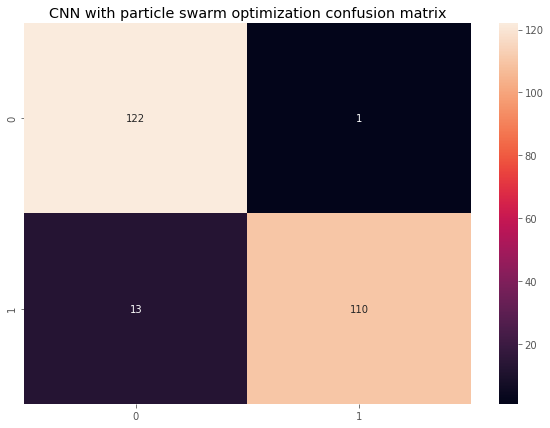

In [156]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cm

df_cm = pd.DataFrame(array)
plt.figure(figsize = (10,7))
plt.title("CNN with particle swarm optimization confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')


### Prediction on Train+Test set

In [157]:
predicted_labels_all = model.predict(features_all,verbose=1)

31/31 [==============================] - 0s 3ms/step


In [158]:
cm = confusion_matrix(labels_all,predicted_labels_all.argmax(axis=1))
cm

array([[491,   1],
       [ 42, 450]])

Train Result:
Accuracy Score: 95.63%
_________________
Classification Report:
                    0           1  accuracy   macro avg  weighted avg
precision    0.921201    0.997783  0.956301    0.959492      0.959492
recall       0.997967    0.914634  0.956301    0.956301      0.956301
f1-score     0.958049    0.954401  0.956301    0.956225      0.956225
support    492.000000  492.000000  0.956301  984.000000    984.000000
_________________
Confusion Matrix: 
 [[491   1]
 [ 42 450]]





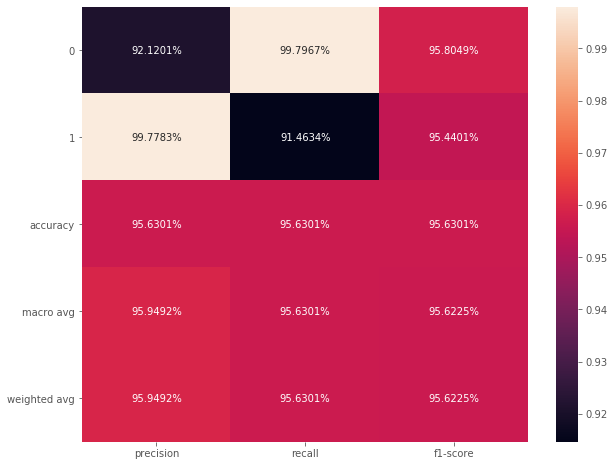

In [159]:
print_score(labels_all, predicted_labels_all.argmax(axis=1))